# Data Preparation

We want to have a monthly episodic dataset so we can compute growth on hive attribute leading to more fair comparison than absolute value. Additonnally we will need the long format to validate any time dependence in the Cubee supplementation impact on survival and other attribute. 

The raw format has one line per inspection event so we want to normalize the pace to one row per month.

In [213]:
from datetime import datetime, date, timedelta

from scipy.stats import gmean
import pandas as pd 
import numpy as np 

from cubee.data.hive import Hive
from cubee.data.queen import Queen
from cubee.data.utils import simple_season
from cubee.configs.filepath import formatted_datapath,raw_datapath

### 0. Load data

In [214]:
d = pd.read_csv(raw_datapath)
print(len(d))
d.head()

39182


/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_30613/1770239349.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(raw_datapath)


,tag_serial_number,hive_age,fob,fobr,foh,brood_pattern,grade,varroa,report_submitted_at,hive_identity_id,...,agressivity,operation_id,is_alive,queen_management,queen_status,state_province_long,country_long,city,yard_type,crop_type
0,277109,0,NaN,NaN,NaN,NaN,Weak,NaN,2022-03-17 19:53:17.868212+00:00,46954,...,NaN,159,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest
1,277109,0,NaN,NaN,NaN,NaN,Weak,NaN,2022-03-17 19:53:50.348010+00:00,46954,...,NaN,159,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest
2,277109,0,NaN,NaN,NaN,NaN,Weak,NaN,2022-03-17 19:53:50.348010+00:00,46954,...,NaN,159,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest
3,277109,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46954,...,NaN,159,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest
4,277109,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46954,...,NaN,159,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest


In [215]:
d['report_submitted_at'] = pd.to_datetime(d['report_submitted_at'])
d['month'] = d['report_submitted_at'].dt.month
d['year'] = d['report_submitted_at'].dt.year 
d['date'] = d['report_submitted_at'].dt.date 

#### 0.1 Compute queen age 

In [218]:
exclude = ['queen cell present', 'queenless', 'capped queen cell',
           'introduced','double queen (for a later split)','queennotright']

queen_ages = []
queen_states = []

for hid in d.hive_identity_id.unique():
    one_hive = d.loc[d['hive_identity_id']==hid].reset_index(drop=True)
    queen_age = None
    queen_state = None
    born_date = None
    for _,row in one_hive.iterrows():
        qn, ts = row['action_detail'],row['report_submitted_at']
        if row['category'] == 'queen management':
            if qn not in exclude:
                if queen_age is None:
                    born_date = ts.date()
                    death_date = ts.date()
                    queen_age = 0
                    queen_state = False
                else:
                    death_date = ts.date()
                    queen_age = abs((death_date-born_date).days)
                    born_date = ts.date()
                    queen_state = True
        else:
            if born_date is not None:
                queen_age = abs((ts.date() - born_date).days)
                queen_state = False
            else:
                queen_age = None
                queen_state = None
        queen_ages.append(queen_age)
        queen_states.append(queen_state)
            
d['queen_age'] = queen_ages
d['queen_state'] = queen_states
d.head()

,tag_serial_number,hive_age,fob,fobr,foh,brood_pattern,grade,varroa,report_submitted_at,hive_identity_id,...,state_province_long,country_long,city,yard_type,crop_type,month,year,date,queen_age,queen_state
0,277108,0,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-17 20:02:16.658582+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-17,NaN,None
1,277108,0,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-17 20:03:17.864504+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-17,NaN,None
2,277108,0,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-17 20:03:17.864504+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-17,NaN,None
3,277108,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-21,NaN,None
4,277108,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-21,NaN,None


In [219]:
### Audio fake hive to be removed 
d = d.loc[d['tag_serial_number']!=277109].reset_index(drop=True)
d.head()

,tag_serial_number,hive_age,fob,fobr,foh,brood_pattern,grade,varroa,report_submitted_at,hive_identity_id,...,state_province_long,country_long,city,yard_type,crop_type,month,year,date,queen_age,queen_state
0,277108,0,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-17 20:02:16.658582+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-17,NaN,None
1,277108,0,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-17 20:03:17.864504+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-17,NaN,None
2,277108,0,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-17 20:03:17.864504+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-17,NaN,None
3,277108,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-21,NaN,None
4,277108,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46955,...,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,3,2022,2022-03-21,NaN,None


In [220]:
d.columns

Index(['tag_serial_number', 'hive_age', 'fob', 'fobr', 'foh', 'brood_pattern',
       'grade', 'varroa', 'report_submitted_at', 'hive_identity_id',
       'category', 'action_detail', 'report_report_type', 'yard_name',
       'report_notes', 'lon', 'lat', 'agressivity', 'operation_id', 'is_alive',
       'queen_management', 'queen_status', 'state_province_long',
       'country_long', 'city', 'yard_type', 'crop_type', 'month', 'year',
       'date', 'queen_age', 'queen_state'],
      dtype='object')

***

### 1.Build dataset

#### 1.1 HIVE LEVEL

1. For each month alive 
2. Compute the max observed frames of bees, frames of brood, varroa, frames of honey, 
3. Compute the geometric mean of aggressvity, brood_pattern
4. Hive age at end of month or latest date observed (died during the month)
5. Hive state at end of month or latest date observed (died during the month)
6. Number of cubee supplementation in the month 
7. Number of hives interacted (in the same yard during at least one day) during the month 
9. Save dataset in an episodic format 

#### 1.2 QUEEN LEVEL
--> Replicate logic above but where queen is first citizen rather than hive.

***

#### 1.1 Hive level

In [236]:
def determine_age_and_state(x):
    if x['queen_state'].max():
        queen_age = x['queen_age'].max()
    else:
        queen_age = x['queen_age'].values[-1]
    return x['is_alive'].min(), x['hive_age'].max(), queen_age, x['queen_state'].max()

In [237]:
def determine_cubee_supplementation_event(x):
    c = 0 
    for _,row in x.iterrows():
        if (row['action_detail'] == 'mushroom') | (row['category'] == 'cubee ml'):
            c=+ 1
    return c 

In [238]:
def determine_fob_fobr_varroa_foh(x):
    return x['varroa'].max(), x['fob'].max(), x['fobr'].max(), x['foh'].max()

In [239]:
def determine_brood_pattern(x):
    if x['brood_pattern'].isnull().mean() < 1.0:
        return gmean(x['brood_pattern'].fillna(x['brood_pattern'].mean()))
    else:
        return None

In [240]:
def determine_stings(x):
    if x['agressivity'].isnull().mean() < 1.0:
        return gmean(x['agressivity'].fillna(x['brood_pattern'].mean()))
    else:
        return None

In [241]:
len(d['hive_identity_id'].unique())

326

In [242]:
def determine_interactions(full, yid, start_of_month, end_of_month):
    subset_full = full.loc[(full['date'] >= start_of_month.date()) & (full['date'] < end_of_month) & (full['yard_name'] ==yid)].reset_index(drop=True)
    return len(subset_full['hive_identity_id'].unique()) - 1

In [258]:
final = []
for hid in d.hive_identity_id.unique():
    queen_id = 0
    one_hive = d.loc[d['hive_identity_id']==hid].reset_index(drop=True)
    one_hive = one_hive.sort_values("report_submitted_at",ascending=True).reset_index(drop=True)
    first_obs = one_hive['report_submitted_at'].min().date() - pd.offsets.MonthBegin()
    last_obs = date.today() + pd.offsets.MonthEnd() if one_hive['is_alive'].min() == 1 else one_hive['date'].max() + pd.offsets.MonthEnd()
    dates = [x.date() for x in pd.date_range(start=first_obs, end=last_obs, freq='ME',inclusive="both").tolist() ]
    results = {d:{"time1":None, "time2":None,"state":None, "hive_age":None, "cubee":0, "fob":None,"fobr":None,"foh":None,"varroa":None,"queen_age":None,"queen_state":None,"queen_cubee":None,"queen_id":None, "brood_pattern":None,"stings":None,"hid":hid,"hive_interacted":None} for d in dates}
    for i,end_of_month in enumerate(dates):
        start_of_month = end_of_month - pd.offsets.MonthBegin()
        days_in_month = (end_of_month - start_of_month.date()).days
        subset = one_hive.loc[(one_hive['date'] >= start_of_month.date()) & (one_hive['date'] < end_of_month)].reset_index(drop=True)
        if len(subset) > 0:
            results[end_of_month]["state"], results[end_of_month]["hive_age"], results[end_of_month]['queen_age'],results[end_of_month]['queen_state'] = determine_age_and_state(subset)
            results[end_of_month]["cubee"] = determine_cubee_supplementation_event(subset)
            results[end_of_month]['varroa'], results[end_of_month]['fob'], results[end_of_month]['fobr'],results[end_of_month]['foh'] = determine_fob_fobr_varroa_foh(subset)
            results[end_of_month]['brood_pattern'] = determine_brood_pattern(subset)
            results[end_of_month]['stings'] = determine_stings(subset)
            results[end_of_month]['hive_interacted'] = determine_interactions(d, subset['yard_name'].values[-1], start_of_month, end_of_month)
            if results[end_of_month]['queen_age'] > 0:
                results[end_of_month]['queen_id'] = f"{hid}_queen_{queen_id}"
                if results[end_of_month]['queen_state']:
                    queen_id += 1
            if i == 0:
                results[end_of_month]['time1'] = 0 
                results[end_of_month]['time2'] = days_in_month 
            else:
                if results[dates[i-1]]['time2']  is not None:
                    results[end_of_month]['time1'] = results[dates[i-1]]['time2'] 
                else:
                    results[end_of_month]['time1'] = 0 
                results[end_of_month]['time2'] = results[end_of_month]['time1'] + days_in_month 
            final.append(results[end_of_month])

    

In [259]:
final_df = pd.DataFrame(final)
final_df.tail()

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_id,brood_pattern,stings,hid,hive_interacted
2843,29,59,1,32,1,3.0,6.0,NaN,5.0,32.0,False,664202_queen_0,5.0,0.0,664202,31
2844,0,29,1,0,0,2.0,2.0,NaN,NaN,0.0,False,None,NaN,NaN,665047,34
2845,29,59,1,30,0,5.0,2.0,NaN,4.0,30.0,False,665047_queen_0,NaN,NaN,665047,31
2846,0,29,1,3,0,5.0,3.0,2.0,NaN,3.0,False,665312_queen_0,NaN,0.0,665312,9
2847,29,59,1,38,0,6.0,3.0,2.0,5.0,38.0,False,665312_queen_0,NaN,0.0,665312,9


In [260]:
final_df.loc[final_df['hid']==661318]

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_id,brood_pattern,stings,hid,hive_interacted
2838,0,29,1,7,1,9.0,5.0,3.0,NaN,7.0,False,661318_queen_0,NaN,0.0,661318,7
2839,29,59,1,39,0,9.0,5.0,3.0,50.0,39.0,False,661318_queen_0,NaN,0.0,661318,7


In [261]:
final_df.describe()

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,brood_pattern,stings,hid,hive_interacted
count,2848.000000,2848.000000,2848.000000,2848.000000,2848.000000,2345.000000,2726.000000,2318.000000,684.000000,1778.000000,1865.000000,1925.000000,2848.000000,2848.00000
mean,67.462079,96.960674,0.918188,221.858497,0.179073,10.956930,4.894718,5.492235,8.608187,139.380202,4.114651,1.329639,206132.839888,17.97823
std,61.426137,61.544988,0.274126,221.611911,0.383481,6.920645,2.805289,4.575052,13.635229,147.075710,1.055437,1.959236,167655.322002,10.83848
min,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,46955.000000,0.00000
25%,0.000000,30.000000,1.000000,62.000000,0.000000,6.000000,3.000000,2.000000,1.000000,36.000000,4.000000,0.000000,68015.000000,7.00000
50%,59.000000,89.000000,1.000000,134.500000,0.000000,9.000000,5.000000,4.000000,3.000000,84.000000,4.299453,0.000000,157146.000000,21.00000
75%,118.000000,148.000000,1.000000,327.000000,0.000000,15.000000,7.000000,7.000000,10.000000,198.000000,5.000000,2.000000,314954.000000,24.00000
max,381.000000,411.000000,1.000000,1239.000000,1.000000,40.000000,20.000000,40.000000,91.000000,802.000000,5.000000,10.000000,665312.000000,42.00000


In [262]:
final_df.to_csv(formatted_datapath,index=False)

# ANNEXE to be move into other notebook

We can see that the effect seems to be constant on time with the age of the colonie. So it doesn't seem we have an age dependent relation with cubee but we may want to look at the queen impact instead.

For the survival analysis, we will build a Bayesian coxPh model where we will stratify by location and test the effect of cubee on longevity. 

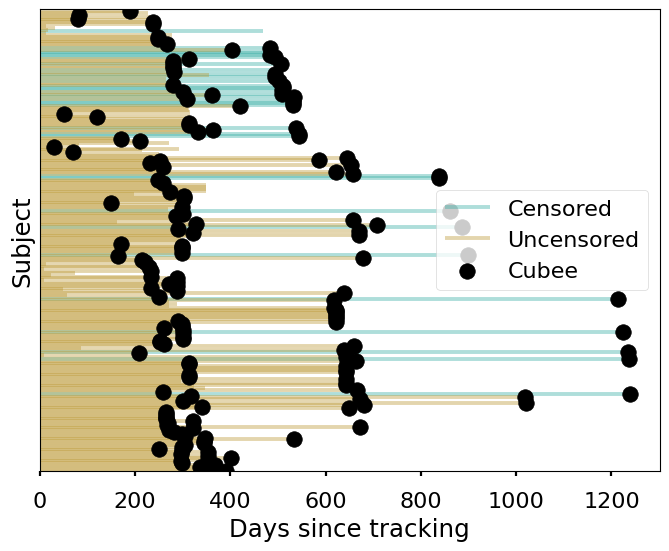

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
first_look['cubee_bool'] = first_look['cubee_spring'] + first_look['cubee_summer']
first_look = first_look.sort_values(["cubee_bool","hive_age"])
ax.hlines(
    first_look[first_look.state==0].index, 0, first_look[first_look.state==0].hive_age, color="C3", label="Censored",alpha=0.4
)

ax.hlines(
    first_look[first_look.state==1].index, 0, first_look[first_look.state==1].hive_age, color="C7", label="Uncensored",alpha=0.4
)

ax.scatter(
    first_look[first_look.cubee.values >0].hive_age,
    first_look[first_look.cubee.values > 0].index,
    color="k",
    zorder=4,
    label="Cubee",
)

ax.set_xlim(left=0)
ax.set_xlabel("Days since tracking")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, len(first_look) + 0.25)

ax.legend(loc="center right");

In [35]:
interval_length = 90
interval_bounds = np.arange(0, first_look.hive_age.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

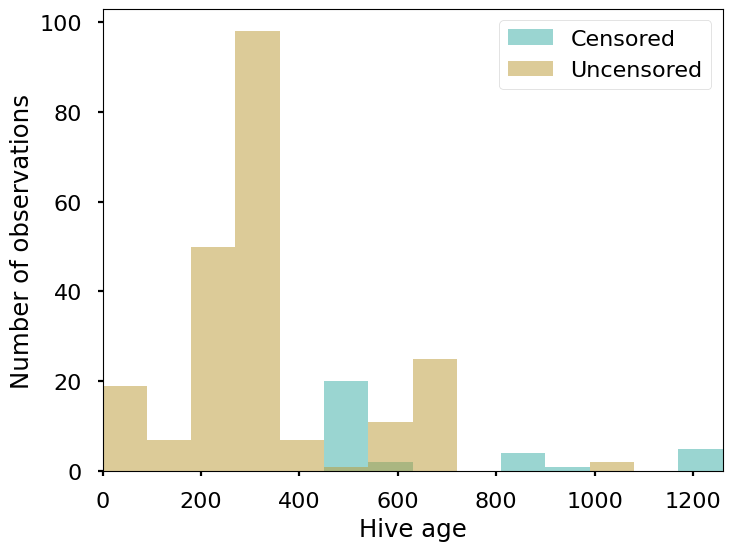

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    first_look[first_look.state == 0].hive_age.values,
    bins=interval_bounds,
    lw=0,
    color="C3",
    alpha=0.5,
    label="Censored",
)

ax.hist(
    first_look[first_look.state == 1].hive_age.values,
    bins=interval_bounds,
    lw=0,
    color="C7",
    alpha=0.5,
    label="Uncensored",
)

ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel("Hive age")

# ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel("Number of observations")

ax.legend();

In [37]:
first_look.state

104     True
110     True
63      True
113     True
239     True
       ...  
65     False
129     True
61     False
118    False
76     False
Name: state, Length: 252, dtype: bool

In [38]:
last_period = np.floor((first_look.hive_age - 0.01) / interval_length).astype(int)
n_hives = len(first_look)
death = np.zeros((n_hives, n_intervals))
death[first_look.index, last_period] = first_look.state.fillna(True)

In [39]:
exposure = np.greater_equal.outer(first_look.hive_age.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[first_look.index, last_period] = first_look.hive_age - interval_bounds[last_period]

In [40]:
n_samples = 300
n_tune = 1000

In [41]:
import pymc as pm
from pytensor import tensor as T
import arviz as az
from pymc.distributions.timeseries import GaussianRandomWalk

In [139]:
LOWER_PRIOR = 1.15
HIGH_PRIOR = 1.35

In [140]:
exposure = np.absolute(exposure)

In [141]:
coords = {"intervals": intervals}

x = first_look['cubee_bool']

with pm.Model(coords=coords) as model:
    lambda0 = pm.Gamma("lambda0", LOWER_PRIOR, HIGH_PRIOR, dims="intervals")

    beta = pm.Normal("beta", 0, sigma=2)

    lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(beta * x), lambda0))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

In [142]:

with model:
    idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=8,
    )

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]
INFO:pymc.sampling.mcmc:NUTS: [lambda0, beta]


Output()

Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 4 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [143]:
base_hazard = idata.posterior["lambda0"]
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"])

In [144]:
coords = {"intervals": intervals}

with pm.Model(coords=coords) as time_varying_model:
    lambda0 = pm.Gamma("lambda0", LOWER_PRIOR, HIGH_PRIOR, dims="intervals")
    beta = GaussianRandomWalk("beta", init_dist=pm.Normal.dist(), sigma=2.0, dims="intervals")

    lambda_ = pm.Deterministic("h", lambda0 * T.exp(T.outer(T.constant(first_look.cubee_bool), beta)))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

In [145]:
with time_varying_model:
    time_varying_idata = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=True,
        target_accept=0.99,
        random_seed=8,
    )

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]
INFO:pymc.sampling.mcmc:NUTS: [lambda0, beta]


Output()

Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 28 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 28 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Create episodic format

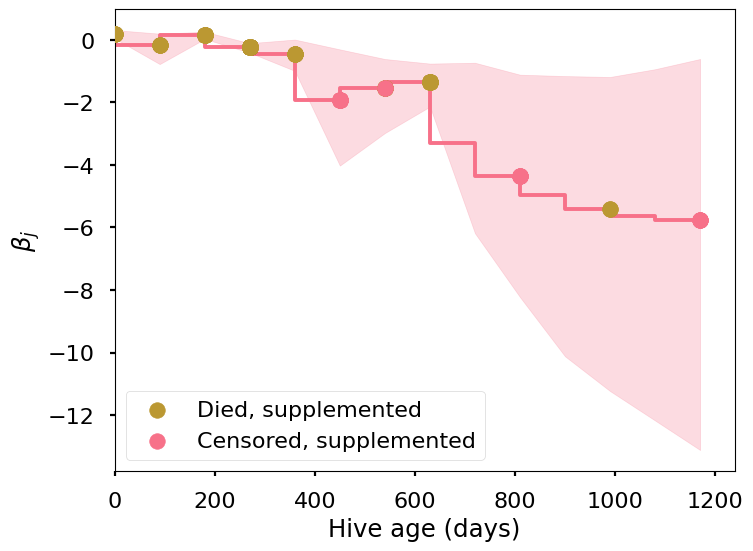

In [146]:
fig, ax = plt.subplots(figsize=(8, 6))

beta_eti = time_varying_idata.posterior["beta"].quantile((0.025, 0.975), dim=("chain", "draw"))
beta_eti_low = beta_eti.sel(quantile=0.025)
beta_eti_high = beta_eti.sel(quantile=0.975)

ax.fill_between(interval_bounds[:-1], beta_eti_low, beta_eti_high, color="C0", alpha=0.25)

beta_hat = time_varying_idata.posterior["beta"].mean(("chain", "draw"))

ax.step(interval_bounds[:-1], beta_hat, color="C0")

ax.scatter(
    interval_bounds[last_period[(first_look.state.values == 1) & (first_look.cubee_bool > 0)]],
    beta_hat.isel(intervals=last_period[(first_look.state.values == 1) & (first_look.cubee_bool > 0)]),
    color="C1",
    zorder=10,
    label="Died, supplemented",
)

ax.scatter(
    interval_bounds[last_period[(first_look.state.values == 0) & (first_look.cubee_bool > 0)]],
    beta_hat.isel(intervals=last_period[(first_look.state.values == 0) & (first_look.cubee_bool > 0)]),
    color="C0",
    zorder=10,
    label="Censored, supplemented",
)

ax.set_xlim(0, first_look.hive_age.max())
ax.set_xlabel("Hive age (days)")
ax.set_ylabel(r"$\beta_j$")
ax.legend();

In [147]:
tv_base_hazard = time_varying_idata.posterior["lambda0"]
tv_met_hazard = time_varying_idata.posterior["lambda0"] * np.exp(
    time_varying_idata.posterior["beta"]
)

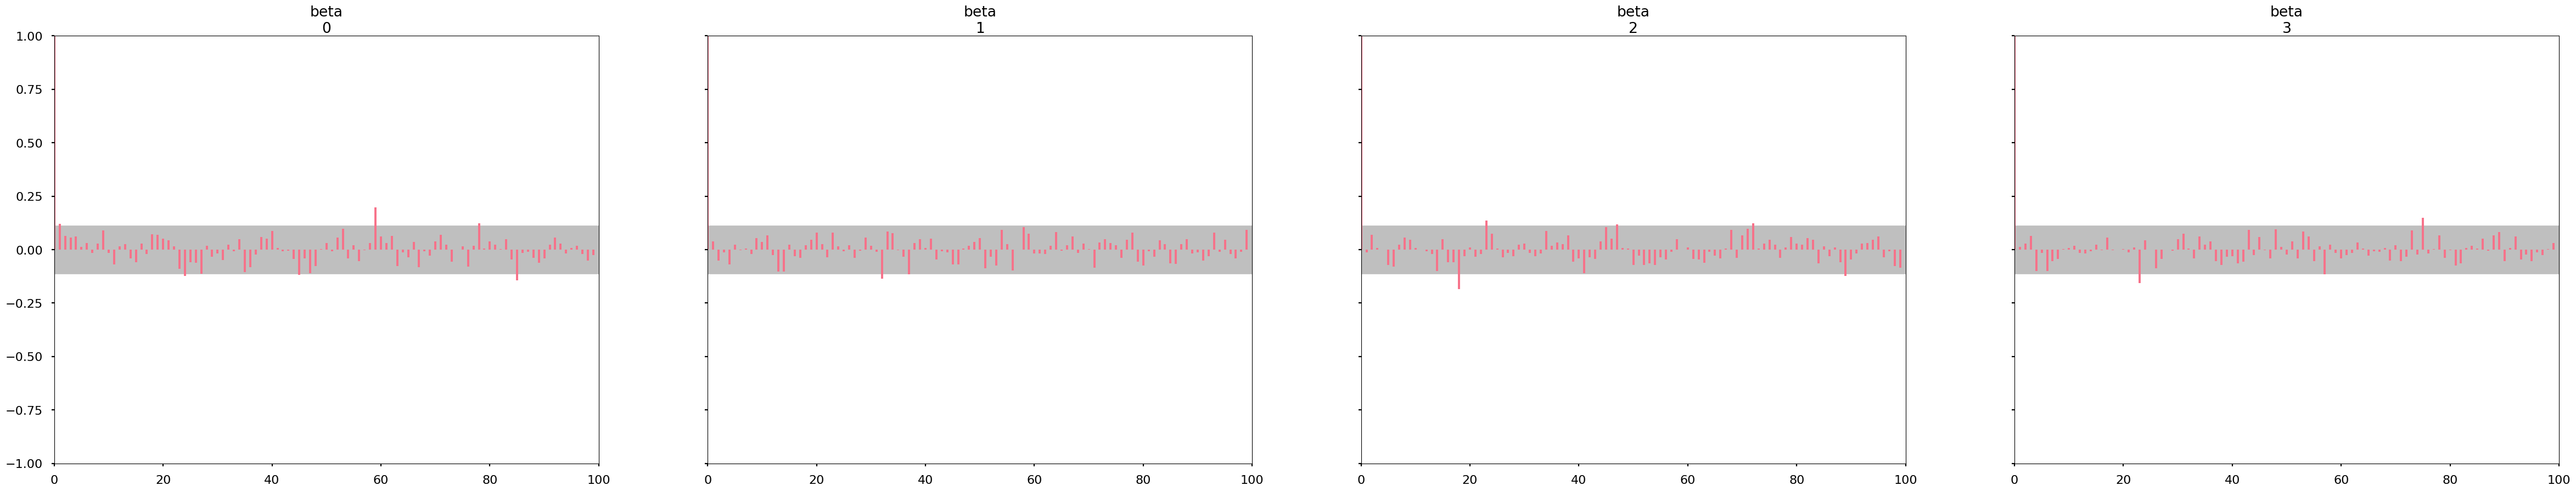

In [148]:
az.plot_autocorr(idata, var_names=["beta"]);

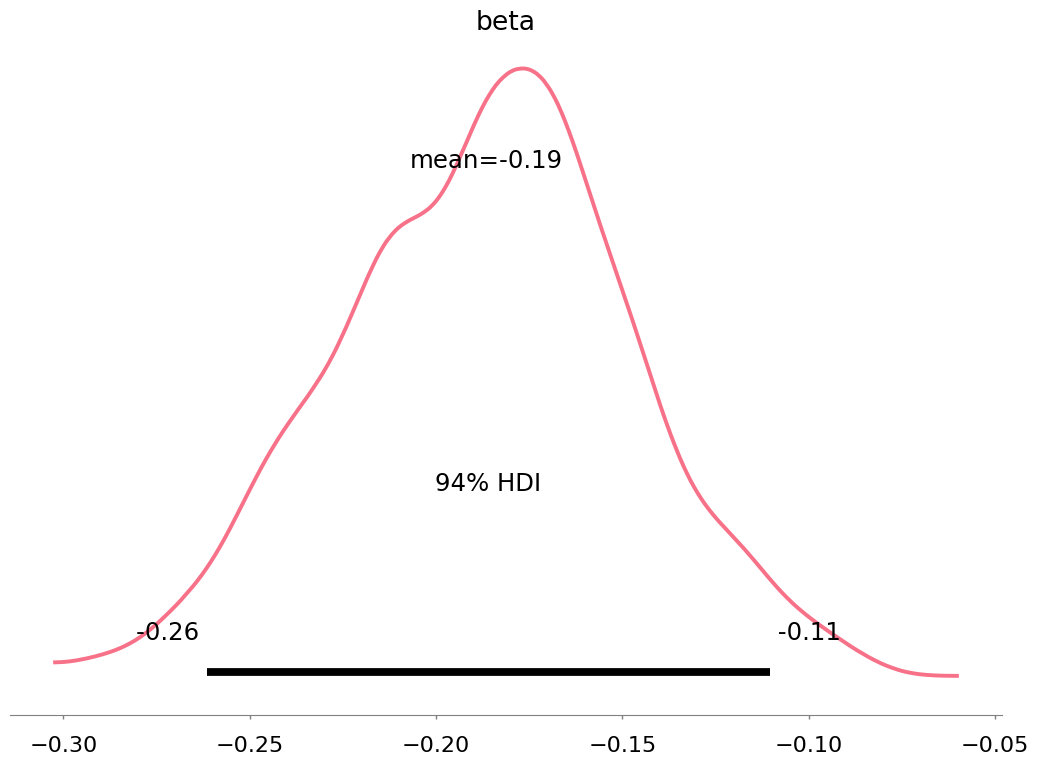

In [149]:
az.plot_posterior(idata, var_names=["beta"]);

In [150]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("chain", "draw"))

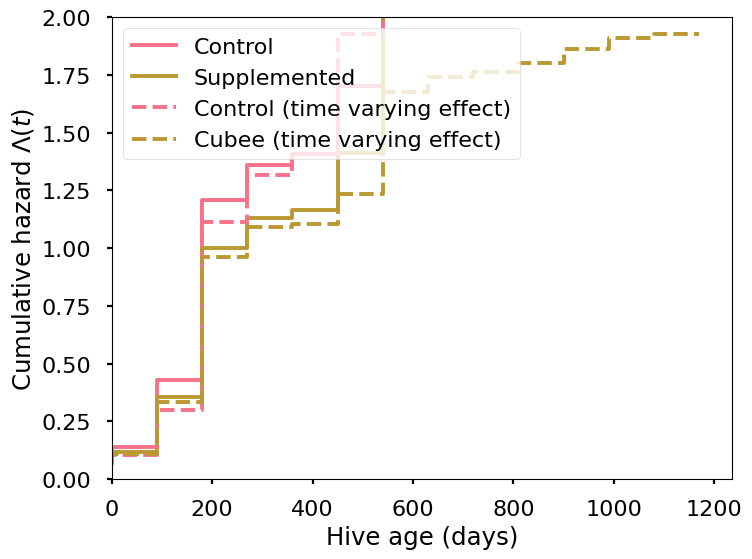

In [151]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.step(
    interval_bounds[:-1],
    cum_hazard(base_hazard.mean(("chain", "draw"))),
    color="C0",
    label="Control",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(met_hazard.mean(("chain", "draw"))),
    color="C1",
    label="Supplemented",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(tv_base_hazard.mean(("chain", "draw"))),
    color="C0",
    linestyle="--",
    label="Control (time varying effect)",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(tv_met_hazard.mean(dim=("chain", "draw"))),
    color="C1",
    linestyle="--",
    label="Cubee (time varying effect)",
)

ax.set_xlim(0, first_look.hive_age.max() - 4)
ax.set_xlabel("Hive age (days)")
ax.set_ylim(0, 2)
ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
ax.legend(loc=2);

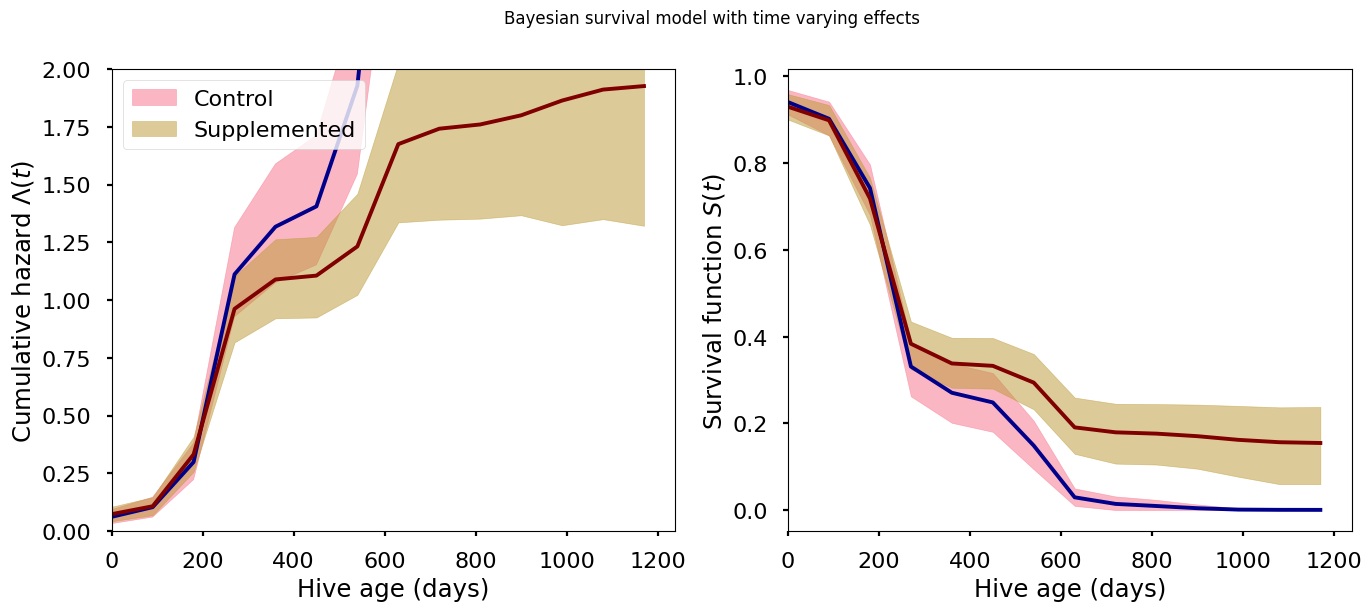

In [152]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(tv_base_hazard),
    ax=hazard_ax,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "Control"},
)

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(tv_met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Supplemented"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(tv_base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(tv_met_hazard)), color="maroon")

hazard_ax.set_xlim(0, first_look.hive_age.max())
hazard_ax.set_xlabel("Hive age (days)")
hazard_ax.set_ylim(0, 2)
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(tv_base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(tv_met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(tv_base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(tv_met_hazard)), color="maroon")

surv_ax.set_xlim(0, first_look.hive_age.max())
surv_ax.set_xlabel("Hive age (days)")
surv_ax.set_ylabel("Survival function $S(t)$")
fig.suptitle("Bayesian survival model with time varying effects");

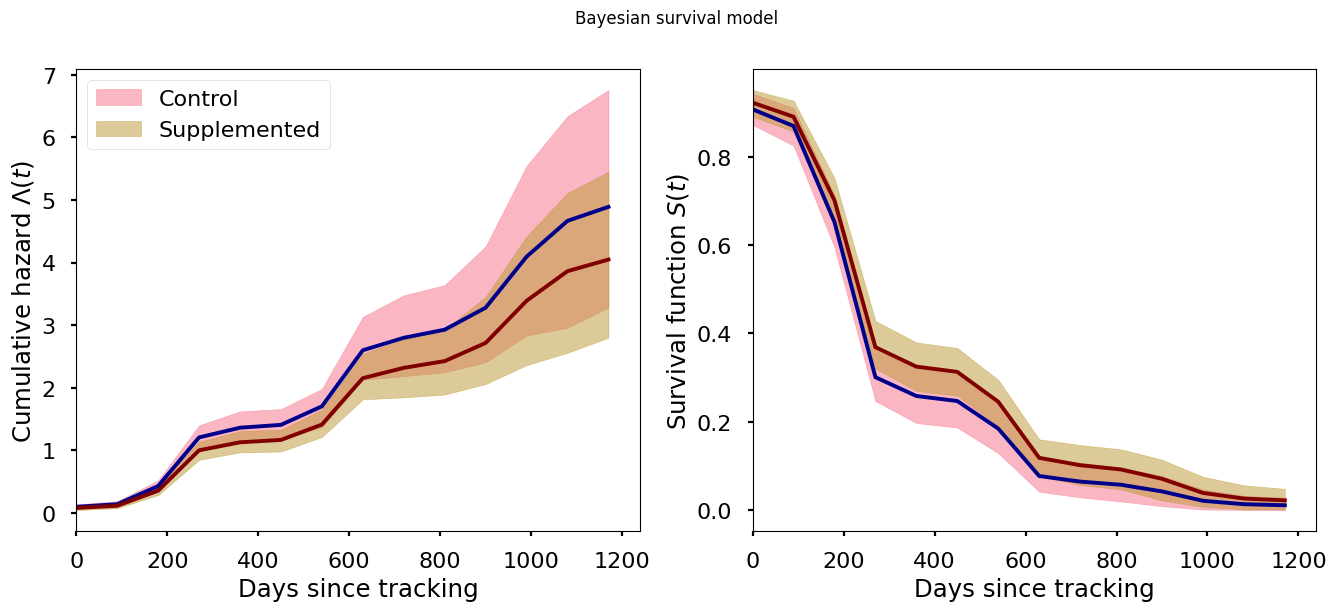

In [153]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Control"},
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Supplemented"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon")

hazard_ax.set_xlim(0, first_look.hive_age.max())
hazard_ax.set_xlabel("Days since tracking")
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")

surv_ax.set_xlim(0, first_look.hive_age.max())
surv_ax.set_xlabel("Days since tracking")
surv_ax.set_ylabel("Survival function $S(t)$")

fig.suptitle("Bayesian survival model");

### Effect on queen longevity

In [138]:
queen_age = []
queen_state = []
queen_cubee = []
queen_provider = []

for h in hives:
    if len(h.queen) > 0:
        for q in h.queen:
            age, state = q._get_state()
            queen_age.append(age)
            queen_state.append(state)
            queen_cubee.append(q.cubee)
            queen_provider.append(q.name)
            

In [58]:
queen_data = pd.DataFrame({"age":queen_age,"state":queen_state,"cubee":queen_cubee,"provider":queen_provider})
queen_data.head()

,age,state,cubee,provider
0,7,True,0,propolis - italienne 2022
1,0,True,0,ukrainienne 2023
2,896,False,0,ukrainienne 2023
3,98,True,0,dorel 2022
4,808,False,0,petit bulldog 2023


In [59]:
queen_data.provider.unique()

array(['propolis - italienne 2022', 'ukrainienne 2023', 'dorel 2022',
       'petit bulldog 2023', 'anicet 2022', 'nico wa 2023',
       'jacques 2022', 'nico wa 2022', 'nico wa 2024 - good mother',
       'flavo', 'gardner 2022', 'melita - buckfast', 'fief',
       'petit bulldog 2022', 'carnica 2022',
       'propolis - buckfast - italy - 2024', 'anicet 2023', 'marie 2023',
       'petit bulldog 2024', 'mestrie - 2024 - batch #2',
       'nico wa 2024 - medium mother',
       'mestrie - chilie - 2024 - batch #1', 'miellerie fief 2024',
       'kevan - weedon - 2023', 'gardner - 2024', 'gardner 2023',
       'wootens', 'maggie - 2022', 'swarm caught - 2024',
       '0277040 - grafter - nico - 2024', 'nico breed 2024'], dtype=object)

In [60]:
queen_data.groupby("cubee").mean(numeric_only=True)

,age,state
cubee,,
0,228.458874,0.623377
1,281.947368,0.421053
2,406.730769,0.461538
3,512.296296,0.481481
4,564.615385,0.461538
5,626.333333,0.333333
6,650.666667,0.666667
7,663.000000,0.666667
8,613.666667,0.333333


In [61]:
cubeed = queen_data.loc[queen_data['cubee'] >0]
not_cubeed = queen_data.loc[queen_data['cubee']==0]

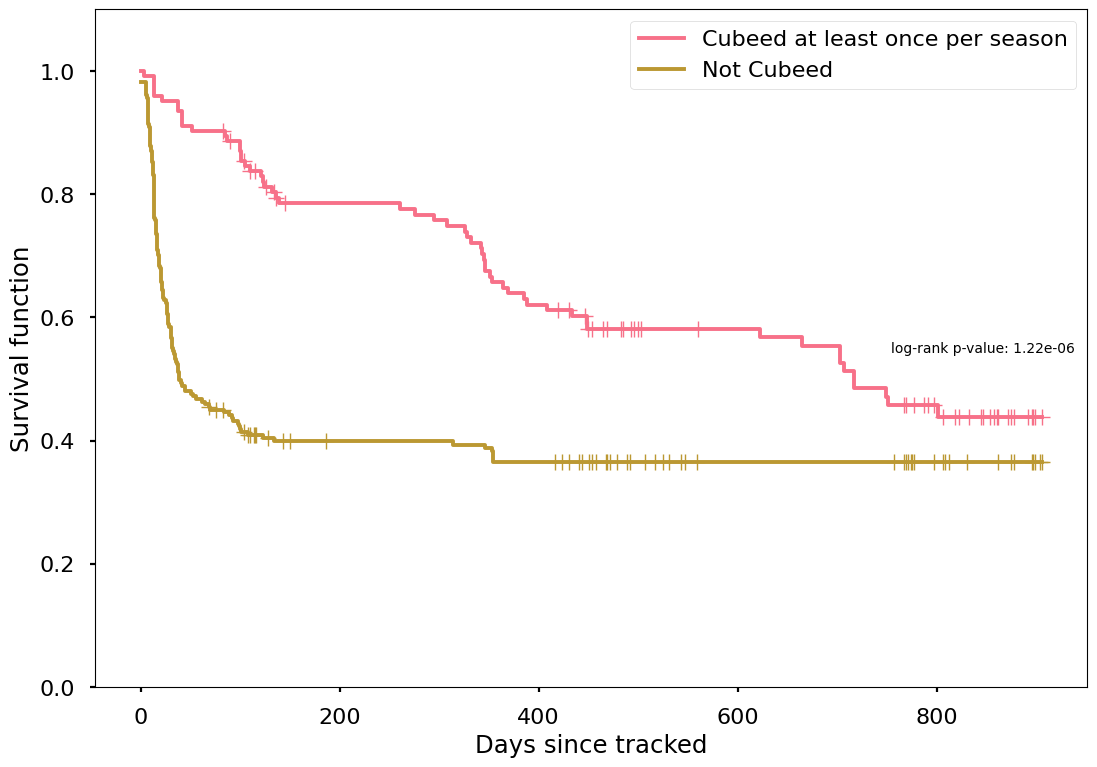

In [62]:

low_results=logrank_test(cubeed['age'],not_cubeed['age'],event_observed_A=cubeed['state'], event_observed_B=not_cubeed['state'])

#Kaplan Meier plot
kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(cubeed['age'], cubeed['state'], label="Cubeed at least once per season").plot(ax=ax, ci_show=False, show_censors=True)
ax = kmf.fit(not_cubeed['age'], not_cubeed['state'], label="Not Cubeed").plot(ax=ax, ci_show=False, show_censors=True)
ax.set_xlabel('Days since tracked')
ax.set_ylabel('Survival function')
plt.ylim([0, 1.1])
anchored_text = AnchoredText("log-rank p-value: {:.3}".format(low_results.p_value), loc=5, frameon=False)
ax.add_artist(anchored_text)
plt.savefig("Queen-survival.png")

Text(0.5, 0, 'time $t$')

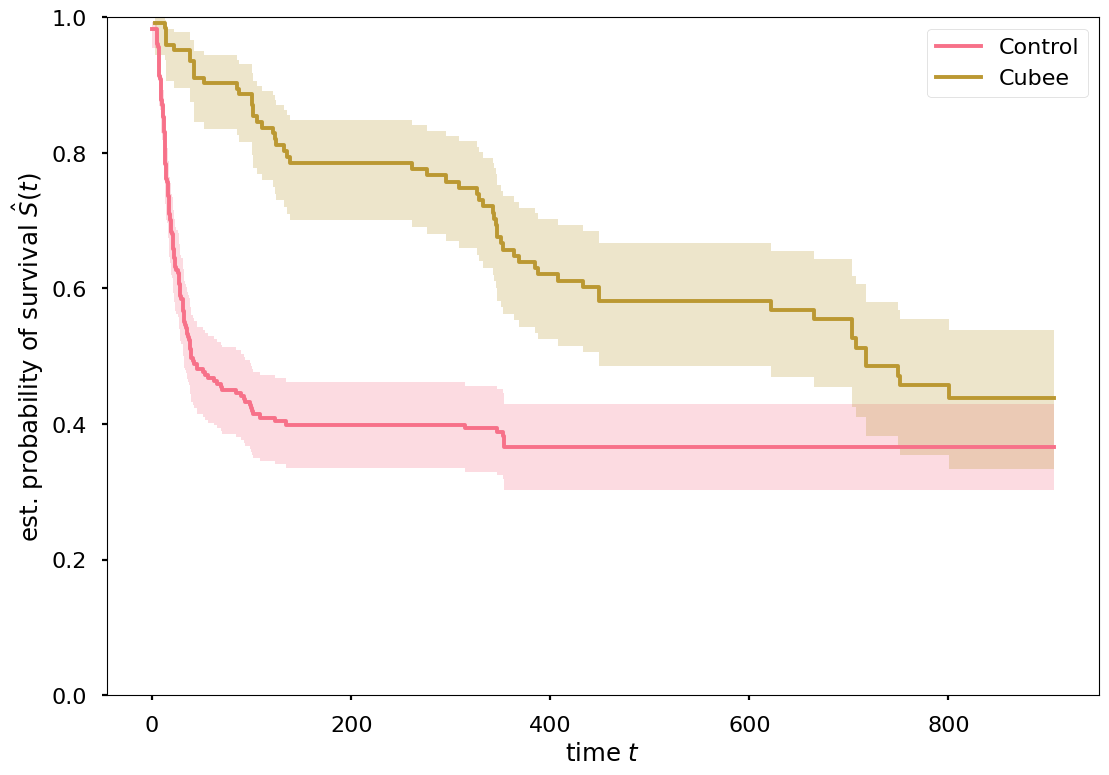

In [63]:
from sksurv.nonparametric import kaplan_meier_estimator

queen_data['state'] = queen_data["state"].apply(lambda x: True if x == 1 else False)

cubeed = queen_data.loc[queen_data['cubee'] >0]
not_cubeed = queen_data.loc[queen_data['cubee']==0]

time, survival_prob, conf_int = kaplan_meier_estimator(
    not_cubeed["state"], not_cubeed["age"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label="Control")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time, survival_prob, conf_int = kaplan_meier_estimator(
    cubeed["state"], cubeed["age"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label="Cubee")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

### Effect on growth of fob and fobr might explain supplementation + after spring strength

- Episofic format needed here to check the timeseries

In [64]:
fob_value = []
fob_date = []
fobr_value = []
hid = []
queen_age = []
cubee = []
lifetime_cubee = []
season = []

for h in hives:
    if len(h.fob) > 0:
        for f in h.fob:
            fob_value.append(f['fob'])
            fobr_value.append(f['fobr'])
            fob_date.append(f['ts'])
            cubee.append(f['cubee'])
            lifetime_cubee.append(f['lifetime_cubee'])
            queen_age.append(f['queen_age'])
            hid.append(h.hid)
            season.append(f['season'])
            

In [65]:
fob_data = pd.DataFrame({"fob":fob_value,"fobr":fobr_value, "date":fob_date,"cubee":cubee,"queen_age":queen_age,"hid":hid, 'season':season,"lifetime_cubee":lifetime_cubee})
# fob_data['date'] = pd.to_datetime(fob_data['date'])
fob_data['hid'] = fob_data['hid'].astype(str)
fob_data['cubee_bool'] = fob_data['lifetime_cubee'] > 0
fob_data['cubee'] = fob_data['cubee'].apply(lambda x: "Cubeed" if x > 1 else "Control")
fob_data.head()

,fob,fobr,date,cubee,queen_age,hid,season,lifetime_cubee,cubee_bool
0,5.0,4.0,2022-06-13 13:17:33.675080+00:00,Control,NaN,46954,2022,0,False
1,5.0,4.0,2022-06-13 13:18:27.145542+00:00,Control,NaN,46954,2022,0,False
2,5.0,4.0,2022-06-13 13:18:27.145542+00:00,Control,NaN,46954,2022,0,False
3,5.0,4.0,2022-06-13 13:18:27.145542+00:00,Control,NaN,46954,2022,0,False
4,5.0,4.0,2022-06-13 13:18:27.145542+00:00,Control,NaN,46954,2022,0,False


28165


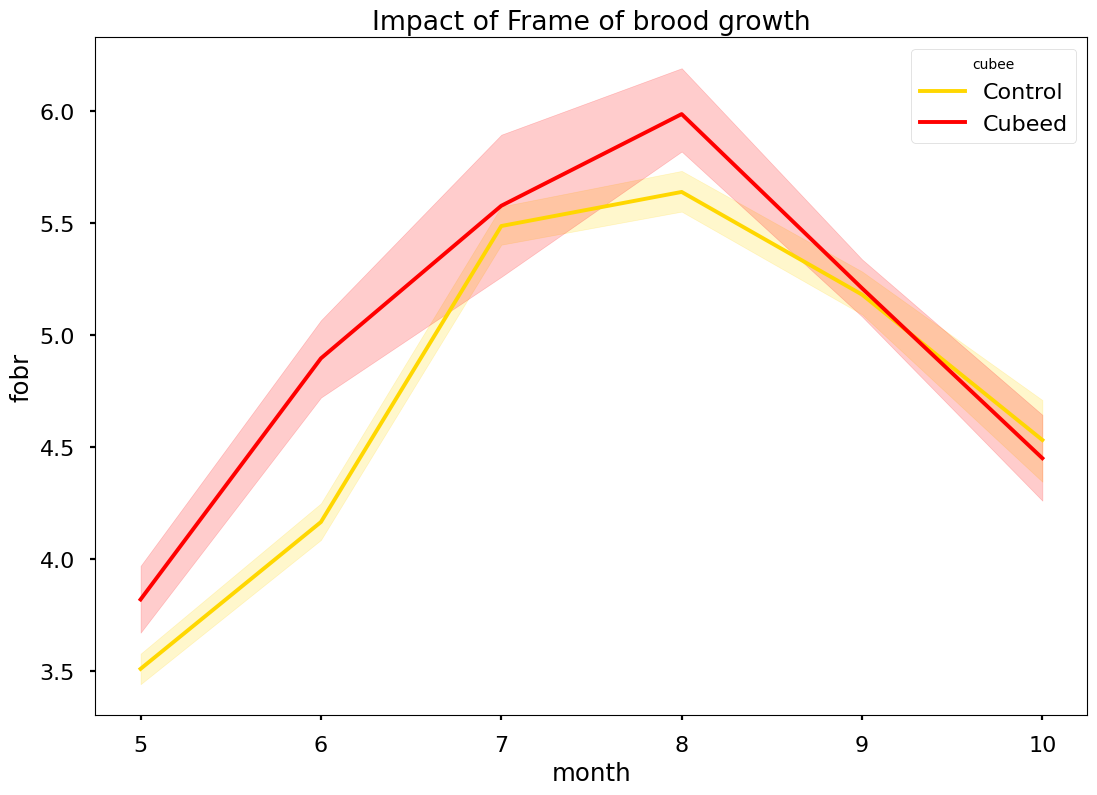

In [66]:
fob_data['month'] = fob_data['date'].dt.month
print(len(fob_data))

sns.lineplot(x="month",y="fobr",hue='cubee',palette={"Cubeed":"red","Control":"gold"},data=fob_data.loc[(fob_data['month'] > 4) & (fob_data['month'] < 11)])
plt.title("Impact of Frame of brood growth")
plt.savefig("fobr_growth.png")

Text(0.5, 1.0, 'Impact of Frame of brood growth')

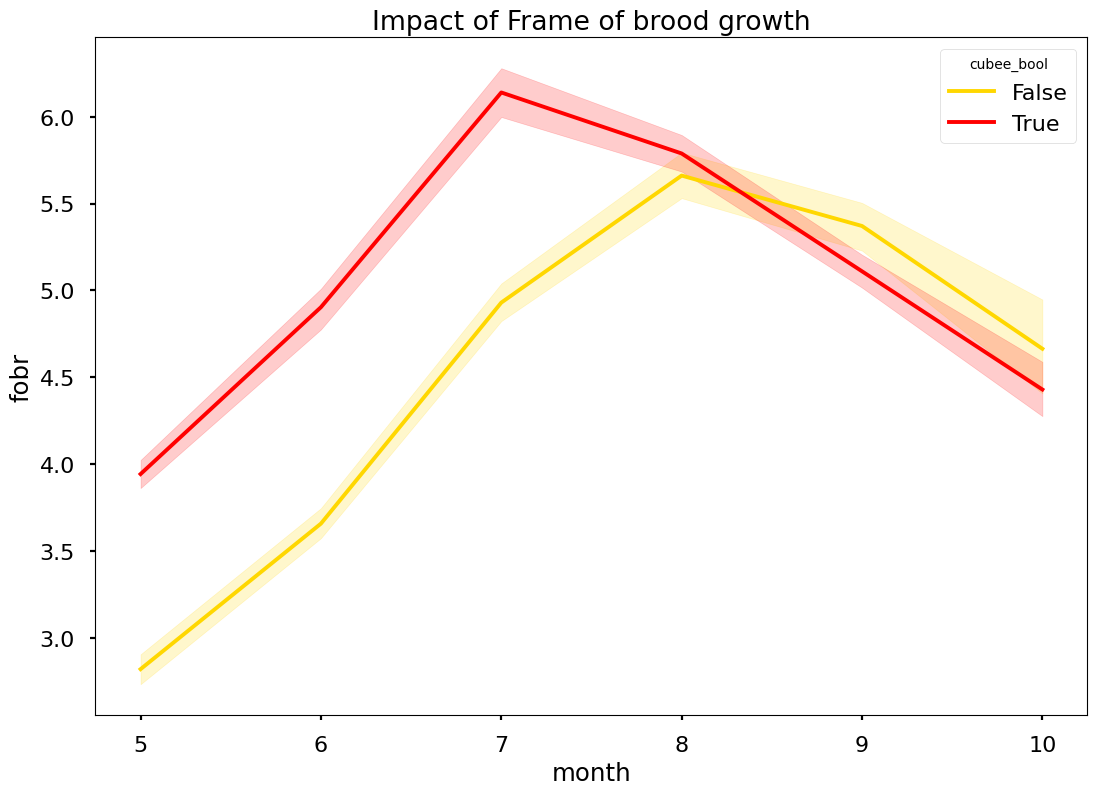

In [67]:
sns.lineplot(x="month",y="fobr",hue='cubee_bool',palette={True:"red",False:"gold"},data=fob_data.loc[(fob_data['month'] > 4) & (fob_data['month'] < 11)])
plt.title("Impact of Frame of brood growth")

#### Compute growth in define period for fair comparison

- Only keep hives active in same period
- Compare initial fob value between groups

In [68]:
# Hives that have at minimum one report from june to september 
fob_data=fob_data.drop_duplicates(["hid","season","month"],keep="last")
fob_data['hid_season'] = f"{fob_data['hid']}_{fob_data['season']}"
t = fob_data.groupby(["hid_season"])['month'].unique().apply(lambda x: len(set(x).intersection(set([6,7,8,9]))) > 2).reset_index()
t.index = t['hid_season'].values
growth_data = fob_data[fob_data.hid_season.isin(t.loc[t['month']].index)]

Text(0.5, 1.0, 'Impact of Frame of brood growth')

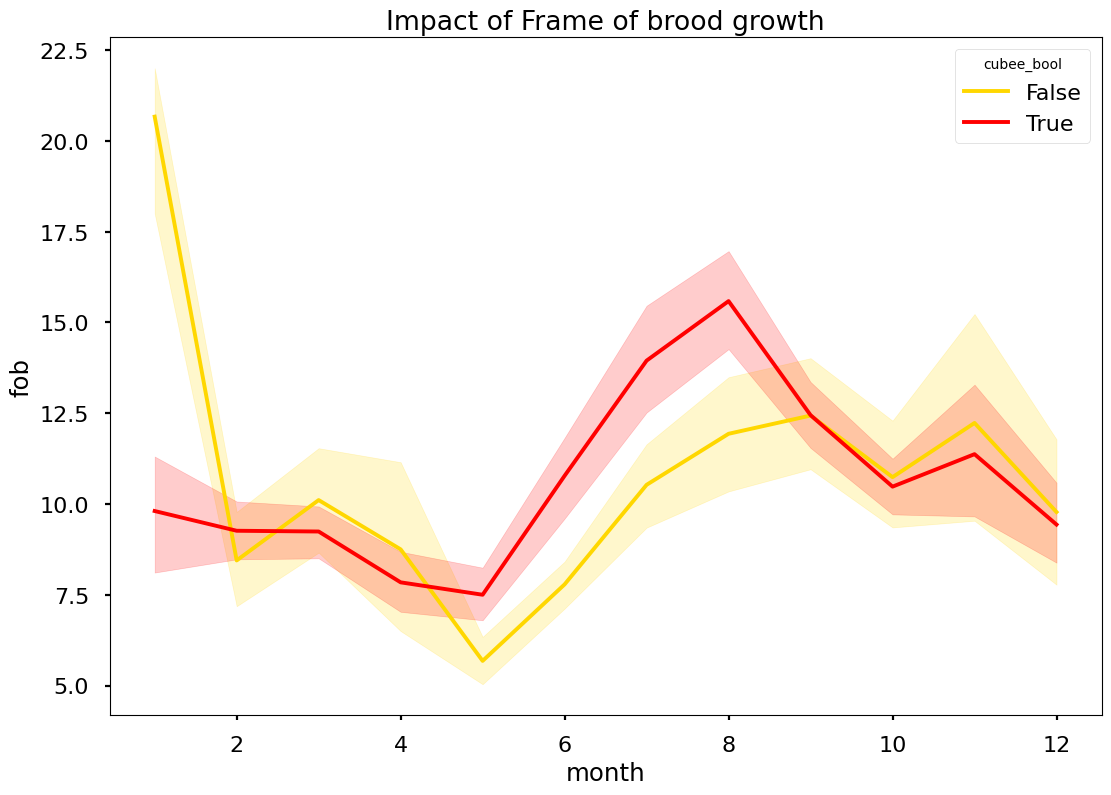

In [69]:
sns.lineplot(x="month",y="fob",hue='cubee_bool',data=growth_data,palette={True:"red",False:"gold"})
plt.title("Impact of Frame of brood growth")

In [70]:
first_value = growth_data.loc[growth_data['month']==6]
last_value = growth_data.loc[growth_data['month']==8]
last_value.head()

,fob,fobr,date,cubee,queen_age,hid,season,lifetime_cubee,cubee_bool,month,hid_season
38,8.0,6.0,2022-08-24 19:02:46.203869+00:00,Control,NaN,46954,2022,0,False,8,13 46954\n25 46954\n38 46...
104,6.0,5.0,2022-08-31 01:32:57.198949+00:00,Control,NaN,46955,2022,1,True,8,13 46954\n25 46954\n38 46...
163,7.0,7.0,2022-08-22 19:01:20.051253+00:00,Control,NaN,55966,2022,0,False,8,13 46954\n25 46954\n38 46...
243,8.0,5.0,2022-08-29 19:44:19.255057+00:00,Control,NaN,55968,2022,1,True,8,13 46954\n25 46954\n38 46...
308,5.0,3.0,2022-08-29 22:12:41.098794+00:00,Control,NaN,55969,2022,1,True,8,13 46954\n25 46954\n38 46...


In [71]:
first_value.rename(columns={"fob":"first_fob","fobr":"first_fobr"},inplace=True)
last_value.rename(columns={"fob":"last_fob","fobr":"last_fobr"},inplace=True)
growth = pd.merge(first_value[['first_fob','first_fobr','hid']], last_value, on="hid")
growth.head()

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_25890/2537442736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_value.rename(columns={"fob":"first_fob","fobr":"first_fobr"},inplace=True)
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_25890/2537442736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_value.rename(columns={"fob":"last_fob","fobr":"last_fobr"},inplace=True)


,first_fob,first_fobr,hid,last_fob,last_fobr,date,cubee,queen_age,season,lifetime_cubee,cubee_bool,month,hid_season
0,8.0,6.0,46954,8.0,6.0,2022-08-24 19:02:46.203869+00:00,Control,NaN,2022,0,False,8,13 46954\n25 46954\n38 46...
1,6.0,6.0,46955,6.0,5.0,2022-08-31 01:32:57.198949+00:00,Control,NaN,2022,1,True,8,13 46954\n25 46954\n38 46...
2,7.0,NaN,55966,7.0,7.0,2022-08-22 19:01:20.051253+00:00,Control,NaN,2022,0,False,8,13 46954\n25 46954\n38 46...
3,8.0,3.0,55968,8.0,5.0,2022-08-29 19:44:19.255057+00:00,Control,NaN,2022,1,True,8,13 46954\n25 46954\n38 46...
4,5.0,3.0,55969,5.0,3.0,2022-08-29 22:12:41.098794+00:00,Control,NaN,2022,1,True,8,13 46954\n25 46954\n38 46...


In [72]:
len(growth)

396

In [73]:
# Compute monthly growth rate , should actually improve and do a geometric average of the monthly rate of augmentation later
growth['growth'] = growth['last_fob']/growth['first_fob']
growth['growth_fobr'] = growth['last_fobr']/(growth['first_fobr']+1.0)
growth.groupby("cubee_bool").mean(numeric_only=True)

,first_fob,first_fobr,last_fob,last_fobr,queen_age,season,lifetime_cubee,month,growth,growth_fobr
cubee_bool,,,,,,,,,,
False,8.931818,4.155039,13.651515,6.174242,593.059524,2023.136364,0.000000,8.0,1.967099,1.639841
True,9.871212,4.484848,17.382576,6.022727,585.536481,2023.723485,4.083333,8.0,2.345973,1.555984


In [74]:
growth['combined'] = growth['growth_fobr'] + growth['growth']

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_25890/1206412432.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(growth.loc[growth['cubee_bool']]['combined'], label=f"cubee n: {len(growth.loc[growth['cubee_bool']])}")
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_25890/1206412432.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.git

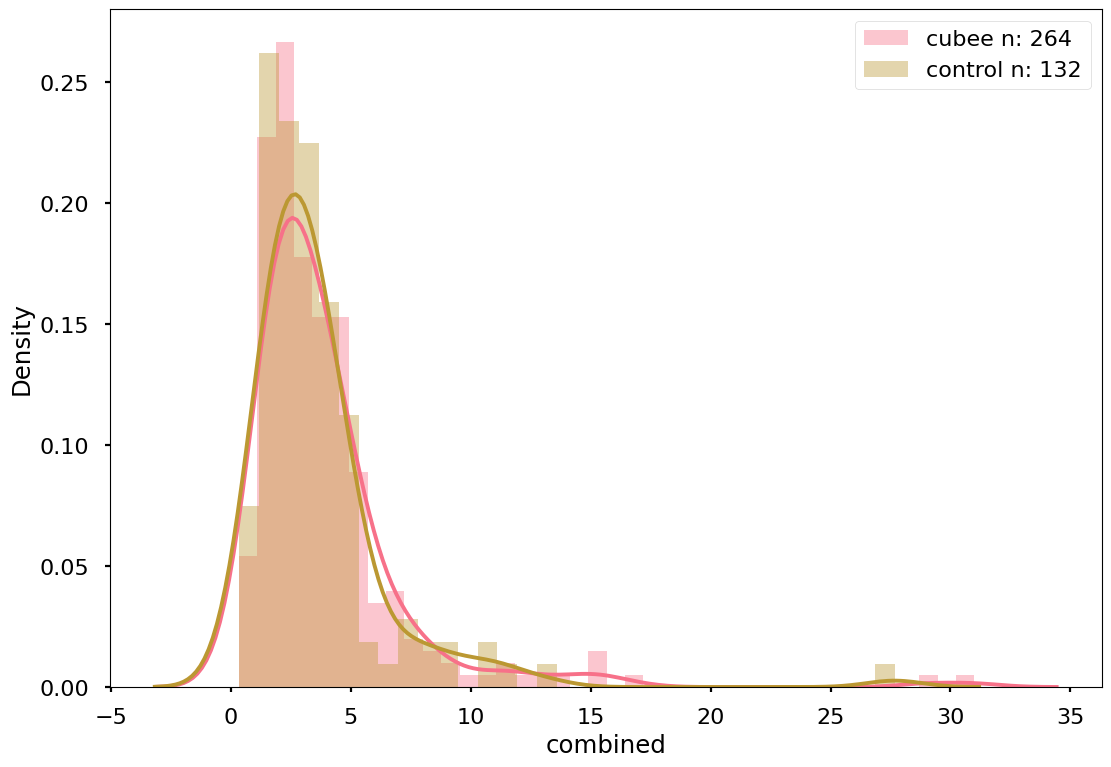

In [75]:
sns.distplot(growth.loc[growth['cubee_bool']]['combined'], label=f"cubee n: {len(growth.loc[growth['cubee_bool']])}")
sns.distplot(growth.loc[~growth['cubee_bool']]['combined'], label=f"control n: {len(growth.loc[~growth['cubee_bool']])}")
plt.legend()

### Honey 

In [76]:
foh_value = []
foh_date = []
hid = []
queen_age = []
cubee = []
season = []
lifetime_cubee = []

for h in hives:
    if len(h.foh) > 0:
        for f in h.foh:
            foh_value.append(f['foh'])
            foh_date.append(f['ts'])
            cubee.append(f['cubee'])
            lifetime_cubee.append(f['lifetime_cubee'])
            queen_age.append(f['queen_age'])
            hid.append(h.hid)
            season.append(f['season'])
            

In [77]:
foh_data = pd.DataFrame({"foh":foh_value,"date":foh_date,"cubee":cubee,"queen_age":queen_age,"hid":hid, 'season':season,"lifetime_cubee":lifetime_cubee})
# fob_data['date'] = pd.to_datetime(fob_data['date'])
foh_data['month'] = foh_data['date'].dt.month
foh_data['hid'] = foh_data['hid'].astype(str)
foh_data['cubee_bool'] = foh_data['lifetime_cubee'] > 0
foh_data = foh_data.loc[foh_data['month'].isin([5,6,7,8,9])]
foh_data = foh_data.sort_values(["hid","date"])
foh_data = foh_data.drop_duplicates(["hid","season","month"])
foh_data.head()

,foh,date,cubee,queen_age,hid,season,lifetime_cubee,month,cubee_bool
14797,5.0,2023-05-05 18:33:32.244104+00:00,0,NaN,150993,2023,0,5,False
14825,3.0,2023-06-02 17:43:36.324892+00:00,0,897.0,150993,2023,0,6,False
14850,2.0,2023-07-03 20:44:49.341804+00:00,0,897.0,150993,2023,0,7,False
14883,2.0,2023-08-10 19:26:53.080578+00:00,1,897.0,150993,2023,1,8,True
14914,7.0,2023-09-26 16:38:38.692851+00:00,3,897.0,150993,2023,3,9,True


In [78]:
# Hives that have at minimum one report from june to september 
foh_data['hid_season'] = f"{foh_data['hid']}_{foh_data['season']}"
t = foh_data.groupby(["hid_season"])['month'].unique().apply(lambda x: len(set(x).intersection(set([6,7,8,9]))) >=3).reset_index()
t.index = t['hid_season'].values
growth_data = foh_data[foh_data.hid_season.isin(t.loc[t['month']].index)]

In [79]:
growth_data.groupby("cubee_bool").count()

,foh,date,cubee,queen_age,hid,season,lifetime_cubee,month,hid_season
cubee_bool,,,,,,,,,
False,468,864,864,296,864,864,864,864,864
True,524,617,617,449,617,617,617,617,617


Text(0.5, 1.0, 'Impact of Frame of honey growth')

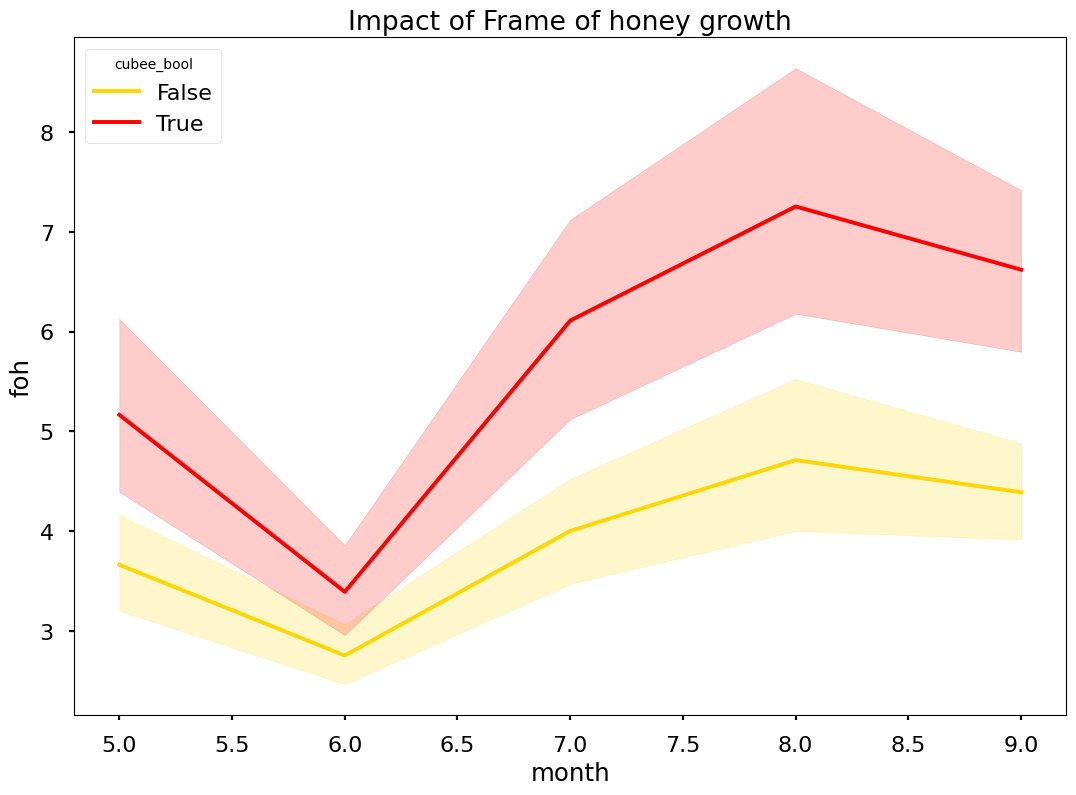

In [80]:
sns.lineplot(x="month",y="foh",hue='cubee_bool',data=growth_data,palette={True:"red",False:"gold"})
plt.title("Impact of Frame of honey growth")

### Aggressivity score 

In [81]:
agg_score = []
date_ = []
hid = []
cubee = []

for h in hives:
    if len(h.agg) > 0:
        for f in h.agg:
            agg_score.append(f['agg_score'])
            date_.append(f['date'])
            cubee.append(f['cubee'])
            hid.append(h.hid)
            

In [82]:
agg_data = pd.DataFrame({"agg_score":agg_score,"date":date_,"cubee":cubee,"hid":hid})
agg_data['gentleness'] = agg_data['agg_score'] == 0.0
agg_data['cubee_bool'] = agg_data['cubee'] > 1

In [83]:
agg_data.groupby("cubee_bool").mean(numeric_only=True)

,agg_score,cubee,hid,gentleness
cubee_bool,,,,
False,1.600655,0.295089,170196.168773,0.259382
True,1.644559,4.210281,152568.336434,0.352795


<Axes: xlabel='cubee_bool', ylabel='gentleness'>

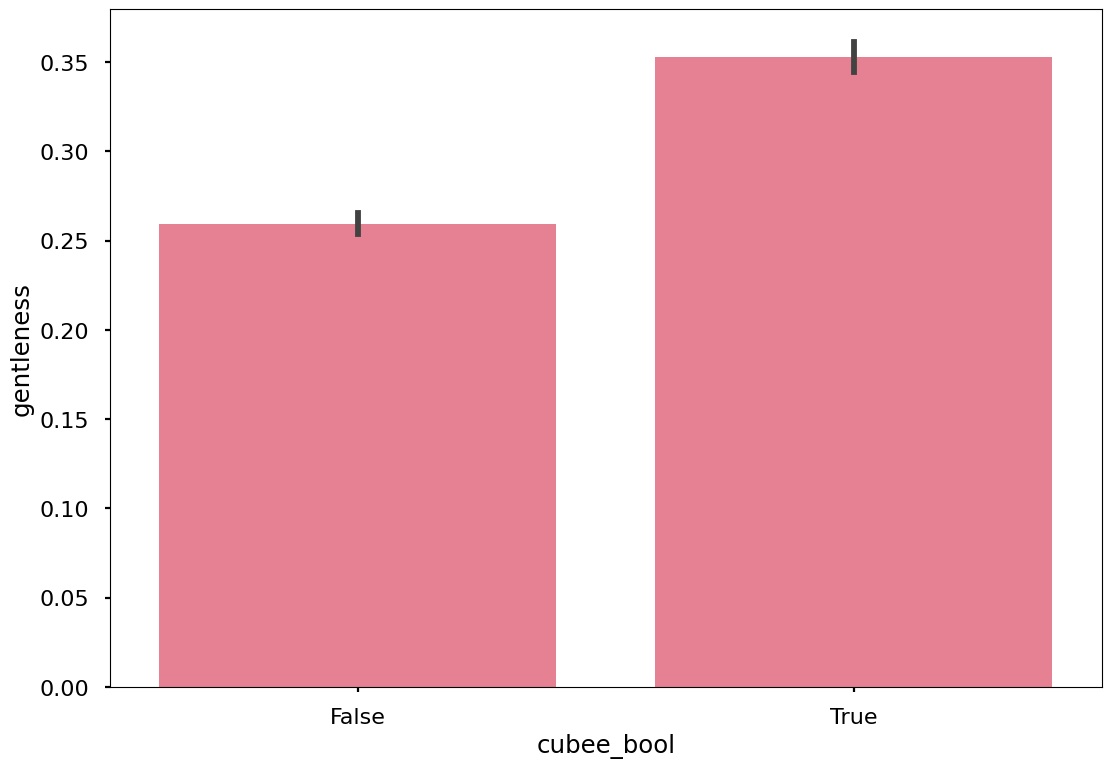

In [84]:
sns.barplot(x="cubee_bool",y="gentleness",data=agg_data)


### Interaction with varroa , due to virus paper and effect on survival 
- Look at impact of over threshold value on colonie growth and longevity

In [85]:
varroa = []
date_ = []
hid = []
cubee = []
hive_age = []
queen_age = []
state = []
fob = []
season = []


for h in hives:
    if len(h.varroa) > 0:
        for f in h.varroa:
            # if (f['lifetime_cubee']-f['cubee'])==0:
            varroa.append(f['varroa'])
            date_.append(f['ts'])
            cubee.append(f['cubee'])
            fob.append(f['fob'])
            state.append(f['state'])
            queen_age.append(f['queen_age'])
            hive_age.append(f['hive_age'])
            hid.append(h.hid)
            season.append(f['season'])
            

### Prepare dataset 

In [86]:
varroa_data = pd.DataFrame({"varroa":varroa,"date":date_,"cubee":cubee,"hid":hid,"alive":state,"hive_age":hive_age,"fob":fob,"queen_age":queen_age,'season':season})
varroa_data['state'] = varroa_data["alive"].apply(lambda x: True if x < 1 else False)
varroa_data['cubee_bool'] = varroa_data['cubee'] > 0

In [87]:
varroa_data.groupby("cubee_bool").mean(numeric_only=True)

,varroa,cubee,hid,alive,hive_age,fob,queen_age,season,state
cubee_bool,,,,,,,,,
False,4.948319,0.000000,163869.503363,0.995044,228.694513,11.319609,675.053125,2023.211681,0.004956
True,6.218758,2.251873,145850.394972,0.997825,292.927967,12.794845,629.086837,2023.226976,0.002175


In [88]:
### Create group of infestion + cubee , infestion not cubee, not infested and infected cubee

In [89]:
vg = varroa_data.groupby("hid").mean().reset_index()
vg['state'] = vg['state'].apply(lambda x: True if x > 0 else False)

Text(0.5, 0, 'time $t$')

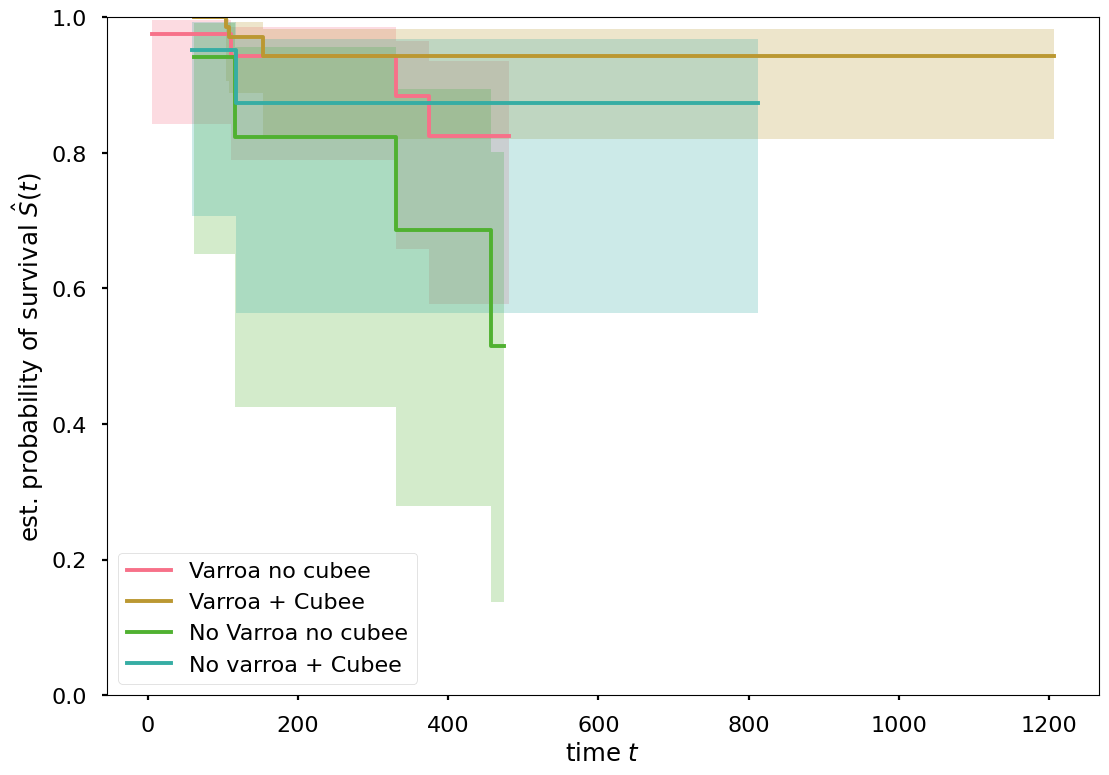

In [90]:
from sksurv.nonparametric import kaplan_meier_estimator


varroa_and_cubee = vg.loc[(vg['cubee'] >1) & (vg['varroa']>=1)]
varroa_no_cubee = vg.loc[(vg['cubee'] ==0) & (vg['varroa']>=1)]
no_varroa_and_cubee = vg.loc[(vg['cubee'] >1) & (vg['varroa']<1)]
no_varroa = vg.loc[(vg['cubee'] ==0) & (vg['varroa']<1)]

time, survival_prob, conf_int = kaplan_meier_estimator(
    varroa_no_cubee["state"], varroa_no_cubee["hive_age"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label="Varroa no cubee")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time, survival_prob, conf_int = kaplan_meier_estimator(
    varroa_and_cubee["state"], varroa_and_cubee["hive_age"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label="Varroa + Cubee")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
time, survival_prob, conf_int = kaplan_meier_estimator(
    no_varroa["state"], no_varroa["hive_age"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label="No Varroa no cubee")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
time, survival_prob, conf_int = kaplan_meier_estimator(
    no_varroa_and_cubee["state"], no_varroa_and_cubee["hive_age"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label="No varroa + Cubee")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

### Linear model with interaction between growth*cubee*varroa 

In [91]:
# d['report_submitted_at'] = pd.to_datetime(d['report_submitted_at'])
# growth_hives = []
# for hid in d.hive_identity_id.unique():
#     subset = d.loc[d['hive_identity_id']==hid].sort_values('report_submitted_at',ascending=True).reset_index(drop=True)
#     # if subset['report_submitted_at'].min() < datetime(2024,9,1,0,0,0).replace(tzinfo=pytz.UTC):
#     hive_age = subset['hive_age'].values[-1]
#     state = subset['is_alive'].values[-1]
#     creation_date = subset['report_submitted_at'].min()
#     hive = Hive(hid,hive_age, state,creation_date)
#     _ = hive.ingest_history(subset)
#     gh = hive.create_monthly_growth_dataset(subset)
#     for k,v in gh.items():
#         v['hid']=hive.hid
#         v['date'] = k 
#         growth_hives.append(v)


# growth_data =pd.DataFrame(growth_hives).dropna(subset=['season'])
# growth_data =  growth_data.sort_values(['hid','date'],ascending=True)
# # growth_data['cubee'] = growth_data.groupby('hid')['cubee'].ffill()
# # growth_data['fob'] = growth_data.groupby('hid')['fob'].ffill()
# # growth_data['fobr'] = growth_data.groupby('hid')['fobr'].ffill()
# growth_data.head(20)

In [92]:
# len(growth_data)

In [93]:
# growth_data['month'] = pd.to_datetime(growth_data['date']).dt.month

In [94]:
# growth_data.hid.value_counts()

In [95]:
# growth_data.isnull().mean()

In [96]:
# growth_data.dtypes

In [97]:
# fob_growth = growth_data.loc[growth_data['month'].isin([5,6,7,8,9,10])]

In [98]:
# summed = fob_growth.groupby(["hid","season"]).sum(numeric_only=True).reset_index()
# summed.head()

In [99]:
# fob_growth.head()

In [100]:
# fob_growth.drop(['cubee'],axis=1,inplace=True,errors='ignore')
# fob_growth = pd.merge(fob_growth,summed[['hid','season','cubee']],on=['hid','season'],how='left')
# fob_growth.head()

In [101]:
# fob_growth = growth_data.loc[growth_data['month'].isin([5,6,7,8,9])]
# fob_growth = fob_growth.loc[fob_growth['is_alive']==1.0]
# fob_growth = fob_growth.dropna(subset="fob")
# fob_growth = fob_growth.sort_values(["hid","date"])
# fob_growth.loc[fob_growth['hid']==665312]

In [102]:
# fob_growth = fob_growth.set_index('date')
# fob_growth['fob_growth'] = fob_growth.groupby('hid')['fob'].pct_change(periods=3)
# fob_growth = fob_growth.dropna(subset="fob_growth")

In [103]:
# fob_growth.head()

In [104]:
# sns.distplot(fob_growth.loc[fob_growth['cubee']==1]['fob'])

### Im here, I want to show the effect of varroa on longevity + cubee 

### Fetch Weather api for external weather impact 

- Compute seasonal feature and check impact of Cubee on growth, longevity

### BayesNet

Build a seasonal dataset (episodic by season)

### Seasonal dataset 

- Adress left censoring by working with rate 
- Episodic format based on the season

In [105]:
from pgmpy.models import DiscreteBayesianNetwork
from IPython.display import Image

In [106]:
cubee_model = DiscreteBayesianNetwork([ 
                                      ('fob', 'varroa'),
                                      ("queen_age","hive_age"),
                                        ("queen_age","fob"),
                                       ('cubee', 'queen_age'),
                                       ('cubee', 'hive_age'),
                                    ('cubee', 'varroa'),
                                    ('cubee', 'fob'),
                                    ('varroa', 'hive_age'),
                                        #  ('growth_varroa', 'varroa'),
                                        # ('growth_fob', 'fob'),
    # ('cubee', 'growth_fob')
    # ('cubee','growth_varroa'),
                                      ])

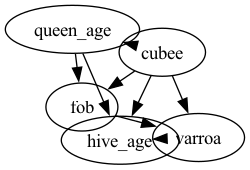

In [107]:
viz = cubee_model.to_graphviz()
viz.draw('cubee_model.png', prog='neato')
Image('cubee_model.png')

### Learn CPD from data

In [108]:
def grade(x):
    if x < 6:
        return 'weak'
    elif (x > 6) and (x < 10):
        return 'medium'
    else:
        return 'strong'

In [109]:
d.loc[d['hive_identity_id']==46954]

,tag_serial_number,hive_age,fob,fobr,foh,brood_pattern,grade,varroa,report_submitted_at,hive_identity_id,...,is_alive,queen_management,queen_status,state_province_long,country_long,city,yard_type,crop_type,cubeed,season
0,277109,0,NaN,NaN,NaN,NaN,Weak,NaN,2022-03-17 19:53:17.868212+00:00,46954,...,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,0,2022
1,277109,0,NaN,NaN,NaN,NaN,Weak,NaN,2022-03-17 19:53:50.348010+00:00,46954,...,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,0,2022
2,277109,0,NaN,NaN,NaN,NaN,Weak,NaN,2022-03-17 19:53:50.348010+00:00,46954,...,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,0,2022
3,277109,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46954,...,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,0,2022
4,277109,4,NaN,NaN,NaN,NaN,Medium,NaN,2022-03-21 20:08:43.433841+00:00,46954,...,1,NaN,NaN,Québec,Canada,Notre-Dame-de-la-Paix,outdoor wintering,Forest,0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,277109,335,8.0,7.0,8.0,5.0,Strong,NaN,2023-02-15 19:03:00.084119+00:00,46954,...,1,NaN,queen cell present,Québec,Canada,Ascot Corner,mating,Wild flower,0,2022
105,277109,335,8.0,7.0,8.0,5.0,Strong,NaN,2023-02-15 19:03:00.084119+00:00,46954,...,1,NaN,queen cell present,Québec,Canada,Ascot Corner,mating,Wild flower,0,2022
106,277109,335,8.0,7.0,8.0,5.0,Strong,NaN,2023-02-15 19:03:00.084119+00:00,46954,...,1,NaN,queen cell present,Québec,Canada,Ascot Corner,mating,Wild flower,0,2022
107,277109,392,8.0,7.0,8.0,5.0,Strong,NaN,2023-04-13 16:31:04.305234+00:00,46954,...,0,NaN,queen cell present,Québec,Canada,Ascot Corner,mating,Wild flower,0,2023


In [110]:
from pgmpy.estimators import ParameterEstimator
import math 
# cubee_model.get_random_cpds(n_states=2, inplace=True)
samples = varroa_data[['varroa', 'state', 'fob', 'queen_age', 'hive_age', 'cubee','season','hid','date']]
samples['month'] = pd.to_datetime(samples['date']).dt.month
# samples = samples.loc[samples['hive_age'] > 365]
# TO DO FIX GROWTH TO BE ON MONTHLY VALUES ONLY SIMILAR FOR AVG 
samples['growth_fob'] = samples.sort_values('date').groupby(['hid', 'season']).fob.pct_change()
samples['growth_varroa'] = samples.sort_values('date').groupby(['hid', 'season']).varroa.pct_change()
samples['growth_varroa'] = samples['growth_varroa'].fillna(method='ffill')
samples['growth_fob'] = samples['growth_fob'].fillna(method='ffill')
avg = samples.loc[samples['month'].isin([6,7,8])].groupby(["hid","season"]).mean(numeric_only=True).reset_index()
samples.drop(["fob","varroa","growth_varroa","growth_fob"],axis=1,inplace=True)
samples = pd.merge(samples,avg[['hid','season','fob','varroa',"growth_varroa","growth_fob"]],on=['hid','season'],how='left')
samples = samples.sort_values(["hid","date"],ascending=True).drop_duplicates(["hid","season"],keep="last")
samples['varroa'] = samples['varroa'].apply(lambda x: "over threshold" if x > 3 else "healthy")
samples.loc[samples['state']==0,'hive_age']=samples['hive_age'].max()
samples['queen_age'] = samples['queen_age'].fillna(samples['queen_age'].max())
samples['queen_age'] = samples['queen_age'].apply(lambda x: math.floor(x/365))
samples['fob'] = samples['fob'].apply(lambda x: grade(x))
samples['hive_age'] = samples['hive_age'] > 365*2
# samples['cubee'] = samples['cubee']/(samples['fob']+10e-6)
# samples['cubee'] = (samples['cubee']).astype(int)
samples['cubee'] = samples['cubee'].apply(lambda x: "cubeed" if x >0 else "control")
samples.head(20)

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_25890/1879395618.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['month'] = pd.to_datetime(samples['date']).dt.month
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_25890/1879395618.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  samples['growth_fob'] = samples.sort_values('date').groupby(['hid', 'season']).fob.pct_change()
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_25890/1879395618.py:10: FutureWarning: Series.fillna with 'method' is depreca

,state,queen_age,hive_age,cubee,season,hid,date,month,fob,varroa,growth_varroa,growth_fob
25,False,2,True,cubeed,2022,46954,2022-11-16 18:19:38.001600+00:00,11,medium,healthy,NaN,0.000000
46,False,2,True,cubeed,2022,46955,2022-12-20 14:27:30.900872+00:00,12,strong,healthy,NaN,0.000000
81,False,2,True,cubeed,2022,55966,2022-10-21 21:20:24.380792+00:00,10,medium,healthy,0.000000,0.000000
114,False,2,True,cubeed,2022,55967,2022-10-28 23:56:28.700849+00:00,10,strong,healthy,0.000000,0.000000
143,False,2,True,cubeed,2022,55968,2022-11-01 18:22:31.077938+00:00,11,medium,healthy,0.000000,0.000000
167,False,2,True,cubeed,2022,55969,2022-11-16 17:14:28.555620+00:00,11,weak,healthy,0.000000,0.000000
195,False,2,True,cubeed,2022,55970,2022-11-16 18:19:38.001600+00:00,11,strong,healthy,-1.000000,0.000000
235,True,2,False,control,2023,55971,2023-05-30 16:05:57.321231+00:00,5,strong,healthy,NaN,NaN
260,False,2,True,cubeed,2022,55972,2022-11-16 18:08:24.937293+00:00,11,strong,healthy,0.000000,0.000000
291,False,2,True,cubeed,2022,55973,2022-10-28 23:56:28.700849+00:00,10,strong,over threshold,0.000000,0.000000


In [111]:
samples.drop(["date","season","hid"],inplace=True,axis=1)
pe = ParameterEstimator(cubee_model, samples)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'state': 'N', 'queen_age': 'N', 'hive_age': 'N', 'cubee': 'C', 'month': 'N', 'fob': 'C', 'varroa': 'C', 'growth_varroa': 'N', 'growth_fob': 'N'}


In [112]:
print("\n", pe.state_counts('cubee'))


          count
cubee         
control     59
cubeed     139


In [113]:
import pprint
# Access attributes of the model
nodes = cubee_model.nodes()
edges = cubee_model.edges()
cpds = cubee_model.get_cpds()

print(f"Nodes in the model: {nodes} \n")
print(f"Edges in the model: {edges} \n")
print(f"CPDs in the model: ")
print(cpds)

Nodes in the model: ['fob', 'varroa', 'queen_age', 'hive_age', 'cubee'] 

Edges in the model: [('fob', 'varroa'), ('varroa', 'hive_age'), ('queen_age', 'hive_age'), ('queen_age', 'fob'), ('cubee', 'queen_age'), ('cubee', 'hive_age'), ('cubee', 'varroa'), ('cubee', 'fob')] 

CPDs in the model: 
[]


In [114]:
samples.head()

,state,queen_age,hive_age,cubee,month,fob,varroa,growth_varroa,growth_fob
25,False,2,True,cubeed,11,medium,healthy,NaN,0.0
46,False,2,True,cubeed,12,strong,healthy,NaN,0.0
81,False,2,True,cubeed,10,medium,healthy,0.0,0.0
114,False,2,True,cubeed,10,strong,healthy,0.0,0.0
143,False,2,True,cubeed,11,medium,healthy,0.0,0.0


In [115]:
from pgmpy.estimators import MaximumLikelihoodEstimator

mle_est = MaximumLikelihoodEstimator(model=cubee_model, data=samples)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'state': 'N', 'queen_age': 'N', 'hive_age': 'N', 'cubee': 'C', 'month': 'N', 'fob': 'C', 'varroa': 'C', 'growth_varroa': 'N', 'growth_fob': 'N'}


In [116]:
print(mle_est.estimate_cpd(node="cubee"))

+----------------+---------+
| cubee(control) | 0.29798 |
+----------------+---------+
| cubee(cubeed)  | 0.70202 |
+----------------+---------+


In [117]:
len(samples)

198

In [118]:
from pgmpy.estimators import BayesianEstimator
# from IPython.core.display import display, HTML

# disable text wrapping in output cell
# display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

cubee_model.cpds = []
cubee_model.fit(data=samples, 
          estimator=BayesianEstimator,
          prior_type="BDeu",
               equivalent_sample_size=10)

print(f'Check model: {cubee_model.check_model()}\n')
for cpd in cubee_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'state': 'N', 'queen_age': 'N', 'hive_age': 'N', 'cubee': 'C', 'month': 'N', 'fob': 'C', 'varroa': 'C', 'growth_varroa': 'N', 'growth_fob': 'N'}


Check model: True

CPT of fob:
+-------------+---------------------+-----+---------------------+
| cubee       | cubee(control)      | ... | cubee(cubeed)       |
+-------------+---------------------+-----+---------------------+
| queen_age   | queen_age(0)        | ... | queen_age(2)        |
+-------------+---------------------+-----+---------------------+
| fob(medium) | 0.07246376811594203 | ... | 0.18350754936120792 |
+-------------+---------------------+-----+---------------------+
| fob(strong) | 0.855072463768116   | ... | 0.7375145180023228  |
+-------------+---------------------+-----+---------------------+
| fob(weak)   | 0.07246376811594203 | ... | 0.07897793263646921 |
+-------------+---------------------+-----+---------------------+ 

CPT of varroa:
+------------------------+-----+---------------+
| cubee                  | ... | cubee(cubeed) |
+------------------------+-----+---------------+
| fob                    | ... | fob(weak)     |
+------------------------+----

In [119]:
# print(f'There can be made {len(cubee_model.get_independencies().get_assertions())}',
#       'valid independence assertions with respect to the all possible given evidence.')
# print('For instance, any node in the network is independent of its non-descendents given its parents (local semantics):\n',
#       f'\n{model.local_independencies(nodes)}\n')

def active_trails_of(query, evidence):
    active = cubee_model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    if active:
        if evidence:
            print(f'Active trails between \'{query}\' and {active} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {active} given no evidence.')
    else:
        print(f'No active trails for \'{query}\' given the evidence {set(evidence)}.')
        
def markov_blanket_of(node):
    print(f'Markov blanket of \'{node}\' is {set(cubee_model.get_markov_blanket(node))}')

active_trails_of(query='hive_age', evidence=[])
active_trails_of(query='hive_age', evidence=['cubee'])
active_trails_of(query='hive_age', evidence=['cubee', 'varroa'])
active_trails_of(query='hive_age', evidence=['cubee','fob','varroa'])
active_trails_of(query='varroa', evidence=['cubee', 'fob'])
print()
markov_blanket_of(node='fob')
markov_blanket_of(node='varroa')
markov_blanket_of(node='hive_age')
markov_blanket_of(node='cubee') 

Active trails between 'hive_age' and {'fob', 'cubee', 'queen_age', 'varroa'} given no evidence.
Active trails between 'hive_age' and {'fob', 'queen_age', 'varroa'} given the evidence {'cubee'}.
Active trails between 'hive_age' and {'queen_age', 'fob'} given the evidence {'varroa', 'cubee'}.
Active trails between 'hive_age' and {'queen_age'} given the evidence {'fob', 'varroa', 'cubee'}.
Active trails between 'varroa' and {'hive_age'} given the evidence {'fob', 'cubee'}.

Markov blanket of 'fob' is {'queen_age', 'varroa', 'cubee'}
Markov blanket of 'varroa' is {'hive_age', 'queen_age', 'fob', 'cubee'}
Markov blanket of 'hive_age' is {'cubee', 'queen_age', 'varroa'}
Markov blanket of 'cubee' is {'queen_age', 'fob', 'varroa', 'hive_age'}


In [120]:
from pgmpy.inference import VariableElimination
import time

def query_report(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    if desc:
        print(desc)
    start_time = time.time()
    print(infer.query(variables=variables, 
                      evidence=evidence, 
                      elimination_order=elimination_order, 
                      show_progress=show_progress))
    print(f'--- Query executed in {time.time() - start_time:0,.4f} seconds ---\n')
    
def get_ordering(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    start_time = time.time()
    ordering = infer._get_elimination_order(variables=variables, 
                                        evidence=evidence, 
                                        elimination_order=elimination_order, 
                                        show_progress=show_progress)
    if desc:
        print(desc, ordering, sep='\n')
        print(f'--- Ordering found in {time.time() - start_time:0,.4f} seconds ---\n')
    return ordering

def padding(heuristic):
    return (heuristic + ":").ljust(16)

def compare_all_ordering(infer, variables, evidence=None, show_progress=False):
    ord_dict = {
        "MinFill": get_ordering(infer, variables, evidence, "MinFill", show_progress),
        "MinNeighbors": get_ordering(infer, variables, evidence, "MinNeighbors", show_progress),
        "MinWeight": get_ordering(infer, variables, evidence, "MinWeight", show_progress),
        "WeightedMinFill": get_ordering(infer, variables, evidence, "WeightedMinFill", show_progress)
    }
    if not evidence:
        pre = f'elimination order found for probability query of {variables} with no evidence:'
    else:
        pre = f'elimination order found for probability query of {variables} with evidence {evidence}:'
    if ord_dict["MinFill"] == ord_dict["MinNeighbors"] and ord_dict["MinFill"] == ord_dict["MinWeight"] and ord_dict["MinFill"] == ord_dict["WeightedMinFill"]:
        print(f'All heuristics find the same {pre}.\n{ord_dict["MinFill"]}\n')
    else:
        print(f'Different {pre}')
        for heuristic, order in ord_dict.items():
            print(f'{padding(heuristic)} {order}')
        print()
            
infer = VariableElimination(cubee_model)

var = ['hive_age']
heuristic = "MinNeighbors"
ordering = get_ordering(infer, variables=var, elimination_order=heuristic,
                        desc=f'Elimination order for {var} with no evidence computed through {heuristic} heuristic:')
query_report(infer, variables=var, elimination_order=ordering, 
             desc=f'Probability query of {var} with no evidence through precomputed elimination order:') 
query_report(infer, variables=var, elimination_order=list(reversed(ordering)), 
             desc=f'Probability query of {var} with no evidence through dummy elimination order:')
compare_all_ordering(infer, variables=var)

var = ['hive_age']
ev = {'cubee': "cubeed", "fob":"weak",'varroa':'over threshold'}
heuristic = "MinFill"
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:')
compare_all_ordering(infer, variables=var, evidence=ev)
heuristic = "MinNeighbors"
ev = {'cubee': "cubeed", "fob":"strong",'varroa':'healthy'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "control", "fob":"strong",'varroa':'healthy'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "control", "fob":"weak",'varroa':'over threshold'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "control", "fob":"weak",'varroa':'healthy'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "cubeed", "fob":"weak",'varroa':'healthy'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

Elimination order for ['hive_age'] with no evidence computed through MinNeighbors heuristic:
['fob', 'queen_age', 'varroa', 'cubee']
--- Ordering found in 0.0006 seconds ---

Probability query of ['hive_age'] with no evidence through precomputed elimination order:
+-----------------+-----------------+
| hive_age        |   phi(hive_age) |
+=================+=================+
| hive_age(False) |          0.1013 |
+-----------------+-----------------+
| hive_age(True)  |          0.8987 |
+-----------------+-----------------+
--- Query executed in 0.0007 seconds ---

Probability query of ['hive_age'] with no evidence through dummy elimination order:
+-----------------+-----------------+
| hive_age        |   phi(hive_age) |
+=================+=================+
| hive_age(False) |          0.1013 |
+-----------------+-----------------+
| hive_age(True)  |          0.8987 |
+-----------------+-----------------+
--- Query executed in 0.0005 seconds ---

All heuristics find the same elimin

In [121]:
# from pgmpy.inference import VariableElimination
# cubee_infer = VariableElimination(cubee_model)

In [122]:
# # Computing the probability of state given cubee 2
# q = cubee_infer.query(variables=["state"], evidence={"cubee": 1.0,"fob":1.0})
# print(q)

# Large scale study, gather Nectar data 

### Effect on longevity 

### Add Weather , Air quality, NDVI, NDWI and check effect in interaction with cubee on longevity

### Nice chart of feature importance and table of stats